In [35]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import holidays
import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [36]:
df = pd.read_csv('2023-2024_booking.csv')
df.drop('booking', axis=1, inplace=True)
df = df.drop_duplicates(subset=['ds'])
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')
df.head()

,ds,y
0,2023-01-01,0.5
1,2023-01-02,0.0
2,2023-01-03,0.0
3,2023-01-04,0.0
4,2023-01-05,0.0


In [37]:
thai_holidays = holidays.Thailand(years=[2023, 2024])
df['is_holiday'] = df['ds'].apply(lambda x: 1 if x in thai_holidays else 0)
df['is_songkran'] = df['ds'].apply(lambda x: 1 if x.month == 4 and 13 <= x.day <= 15 else 0)
df['day_of_week'] = df['ds'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_long_weekend'] = 0

# หาวัน long weekend
for i in range(1, len(df) - 1):
    if df.iloc[i]['is_holiday'] == 1:
        if df.iloc[i - 1]['day_of_week'] == 4 or df.iloc[i + 1]['day_of_week'] == 0:
            df.iloc[i, df.columns.get_loc('is_long_weekend')] = 1

# Lag Features
df['y_lag7'] = df['y'].shift(7)
df['y_lag14'] = df['y'].shift(14)

# Rolling Mean
df['rolling_mean_7'] = df['y'].rolling(window=7).mean()
df['rolling_std_7'] = df['y'].rolling(window=7).std()

# Fill missing with backfill
df.fillna(method='bfill', inplace=True)

In [38]:
train_df = df[df['ds'] < '2024-01-01'].copy()
test_df = df[(df['ds'] >= '2024-04-01') & (df['ds'] <= '2024-04-30')].copy()

In [39]:
trend_model = Prophet()
trend_model.fit(train_df[['ds', 'y']])
trend_forecast = trend_model.predict(test_df[['ds']])
test_df['trend'] = trend_forecast['yhat'].values

22:47:22 - cmdstanpy - INFO - Chain [1] start processing
22:47:22 - cmdstanpy - INFO - Chain [1] done processing


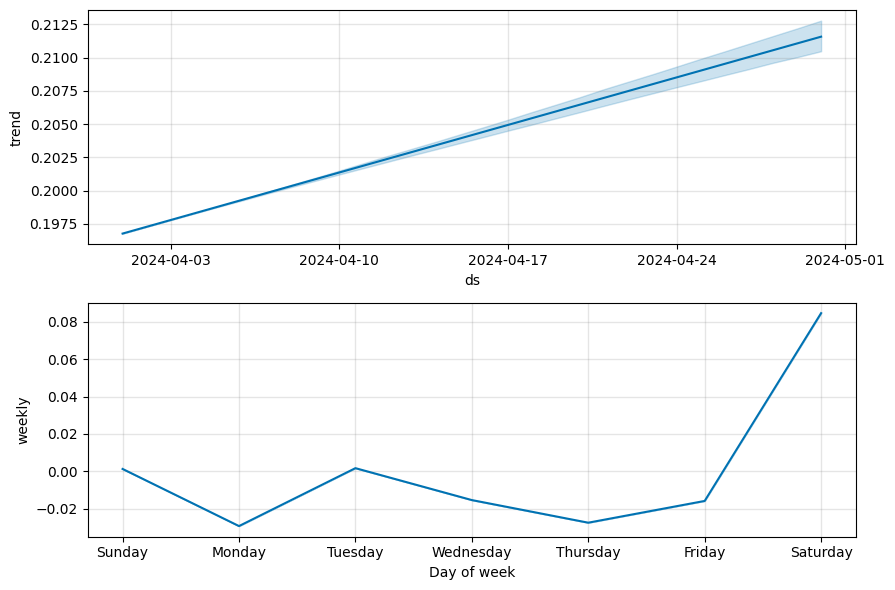

In [40]:
fig = trend_model.plot_components(trend_forecast)
plt.show()


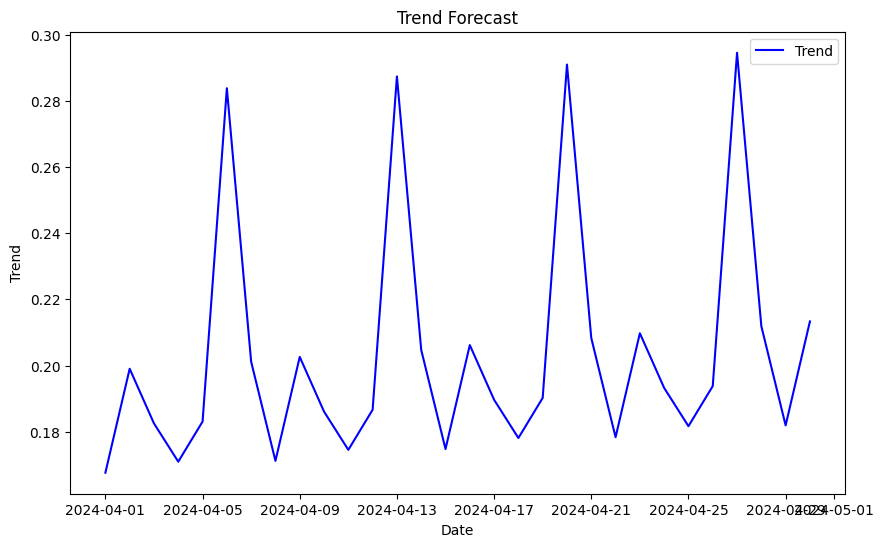

In [41]:
# Plot trend using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['trend'], label='Trend', color='blue')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title('Trend Forecast')
plt.legend()
plt.show()


In [42]:
def event_multiplier(row):
    multiplier = 1.0
    if row['is_holiday'] == 1:
        multiplier *= 1.05
    if row['is_songkran'] == 1:
        multiplier *= 1.90
    if row['is_long_weekend'] == 1:
        multiplier *= 1.10
    return multiplier

test_df['event_multiplier'] = test_df.apply(event_multiplier, axis=1)
test_df['yhat_combined'] = test_df['trend'] * test_df['event_multiplier']

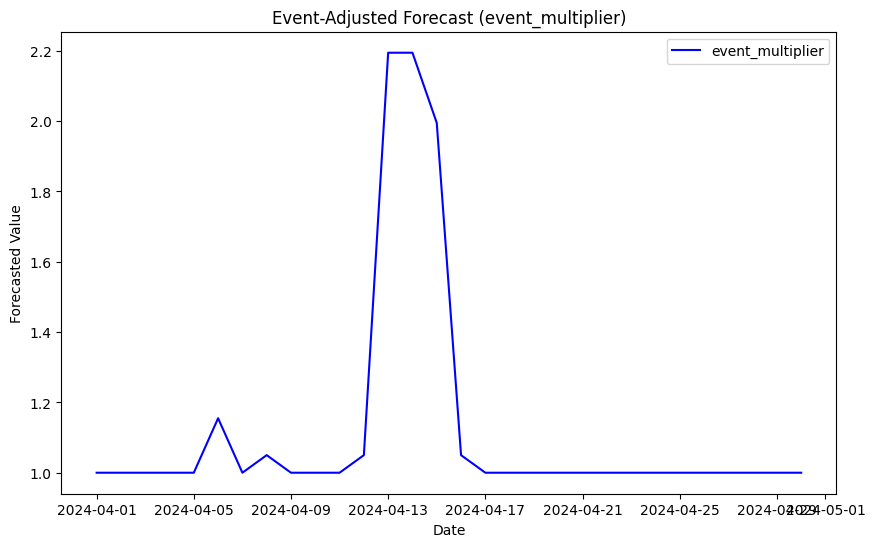

In [44]:
# Plot event_multiplier
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['event_multiplier'], label='event_multiplier', color='blue')
plt.xlabel('Date')
plt.ylabel('Forecasted Value')
plt.title('Event-Adjusted Forecast (event_multiplier)')
plt.legend()
plt.show()


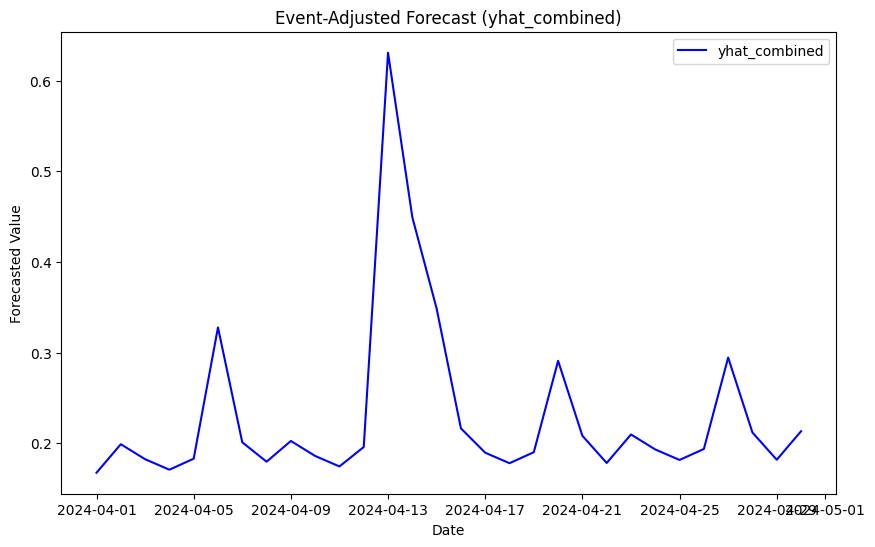

In [ ]:
# Plot yhat_combined
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['yhat_combined'], label='yhat_combined', color='blue')
plt.xlabel('Date')
plt.ylabel('Forecasted Value')
plt.title('Event-Adjusted Forecast (yhat_combined)')
plt.legend()
plt.show()


In [45]:
non_zero_df = test_df[test_df['y'] != 0]
mae = mean_absolute_error(non_zero_df['y'], non_zero_df['yhat_combined'])
mape = mean_absolute_percentage_error(non_zero_df['y'], non_zero_df['yhat_combined'])

print(f"✅ MAE (Hybrid): {mae:.4f}")
print(f"✅ MAPE (Hybrid): {mape * 100:.2f}%")

✅ MAE (Hybrid): 0.1142
✅ MAPE (Hybrid): 31.90%


In [46]:
trend_forecast_train = trend_model.predict(train_df[['ds']])
train_df['trend'] = trend_forecast_train['yhat'].values
train_df['event_multiplier'] = train_df.apply(event_multiplier, axis=1)

# STEP 7: HYBRID MODEL (XGBoost)
features = ['trend', 'event_multiplier', 'day_of_week', 'is_weekend',
            'is_holiday', 'is_songkran', 'is_long_weekend',
            'y_lag7', 'y_lag14', 'rolling_mean_7', 'rolling_std_7']

x_train = train_df[features]
y_train = train_df['y']
x_test = test_df[features]

lgbm_model = LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    n_estimators=200,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgbm_model.fit(x_train, y_train)
test_df['yhat_hybrid'] = lgbm_model.predict(x_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 365, number of used features: 9
[LightGBM] [Info] Start training from score 0.089644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [47]:
non_zero_df = test_df[test_df['y'] != 0]
mae = mean_absolute_error(non_zero_df['y'], non_zero_df['yhat_hybrid'])
mape = mean_absolute_percentage_error(non_zero_df['y'], non_zero_df['yhat_hybrid'])

print(f"✅ MAE (Hybrid): {mae:.4f}")
print(f"✅ MAPE (Hybrid): {mape * 100:.2f}%")

✅ MAE (Hybrid): 0.1099
✅ MAPE (Hybrid): 29.56%


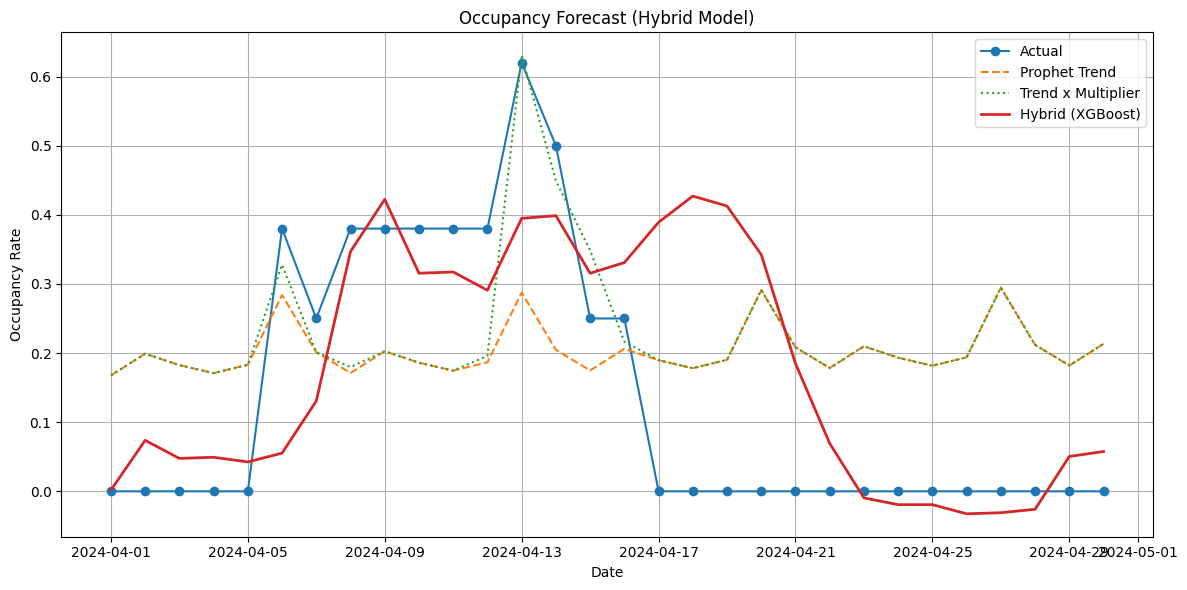

In [48]:
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(test_df['ds'], test_df['trend'], label='Prophet Trend', linestyle='--')
plt.plot(test_df['ds'], test_df['yhat_combined'], label='Trend x Multiplier', linestyle=':')
plt.plot(test_df['ds'], test_df['yhat_hybrid'], label='Hybrid (XGBoost)', linewidth=2)
plt.title('Occupancy Forecast (Hybrid Model)')
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
